In [69]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plts
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd


# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个差值的欧氏距离，并求和
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

def interpolate_to_fixed_points(sorted_curve_bs, target_points=120):
    """
    将 (n, m, 3) 形状的 3D 曲线数据插值为 (n, target_points, 3) 形状的数据。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    target_points (int): 插值后的目标点数，默认值为 120。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 119, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 120, 3)
    
    for i in range(n):
        for j in range(d):  # 对每个维度 (x, y, z) 单独进行插值
            original_points = sorted_curve_bs[i, :, j]
            original_indices = np.linspace(0, 1, m)  # 原始曲线的归一化位置
            target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
            interpolator = interp1d(original_indices, original_points, kind='linear')
            interpolated_data[i, :, j] = interpolator(target_indices)  # 在目标点上插值
    
    return interpolated_data


curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_bs = interpolate_to_fixed_points(curve_bs, 120)
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_abj/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)

original_centerlines = []
abscissas = []
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))



original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

print (files_label)


curve_bs.shape: (79, 120, 3)
files length: 79
79.2532107896111 0.9869818541091827
71.2856941716775 0.97969640320649
81.99732061168635 0.9869708661180842
76.84593306337732 0.985552358848905
84.42219706515498 0.9856562665924893
82.51976985095165 0.9857059903407425
68.148084887353 0.9839196017540927
70.29056645709093 0.9856096752724027
62.64020846369101 0.9862707213605756
59.226106217694706 0.9894545732245174
81.17170446694841 0.9860333361150141
72.55681136334347 0.9863558192861968
89.5732780821605 0.98626210567097
72.3216727210226 0.9850077256302018
93.31776822887464 0.9800208810482752
90.63102213378802 0.9799124255518873
68.49260917930133 0.9867265172435454
66.34326470721825 0.9856978622768328
78.0194813057584 0.9846759712726805
73.91862181493943 0.9796897605668771
80.31522199885775 0.9783325231411466
80.39740696301176 0.9873605080975127
72.8872951189621 0.9839847814572922
72.45990096976132 0.9832474397223351
87.92834101687788 0.9847773666402796
84.83146452428466 0.9827367287188268
77.2

In [70]:
k_sampling_points = 121

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_bs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_


print ("mean_estimate.shape:", mean_estimate.shape)


mean_estimate.shape: (120, 3)


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


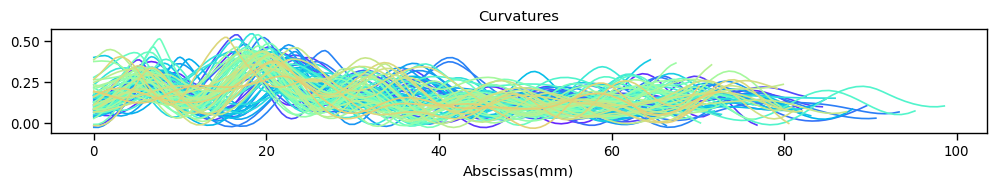

In [71]:


def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


curvatures = []
torsions = []
lengths = []
for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(original_centerlines[i])
    fft_c = remove_high_freq_components(c,0.05)
    fft_t = remove_high_freq_components(t,0.05)
    curvatures.append(fft_c)
    lengths.append(calculate_curve_length(original_centerlines[i]))
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)
lengths = np.array(lengths)

# 假设 curve_cs、abscissas、curvatures、torsions 已定义
# 使用 viridis 调色板
num_curves = len(curve_cs)
# colors = cm.hsv(np.linspace(0, 1, num_curves))  # 为每条曲线生成一个颜色
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
sns.set_context("paper", font_scale=1.1)
fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(212)

for i in range(num_curves):
    ax1.plot(abscissas[i], curvatures[i], color=colors[i], label='curve {}'.format(i))
    # ax2.plot(abscissas[i], torsions[i], color=colors[i], label='curve {}'.format(i))

ax1.set_title('Curvatures')
# ax2.set_title('Torsions')
ax1.set_xlabel('Abscissas(mm)')
# ax2.set_xlabel('Abscissas(mm)')


plt.tight_layout()
plt.show()

In [72]:
print (files_label)

import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

def read_vtk_maximum_inscribed_sphere(file_path):
    """
    Reads a .vtk file and extracts point data with the name 'MaximumInscribedSphere'.

    Parameters:
        file_path (str): The path to the .vtk file.

    Returns:
        np.ndarray: The array of 'MaximumInscribedSphere' data, or None if not found.
    """
    # Create a VTK reader
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Get the data from the file
    data = reader.GetOutput()

    if data is None:
        raise ValueError(f"No data found in file: {file_path}")

    # Get point data
    point_data = data.GetPointData()
    if point_data is None:
        raise ValueError("No point data found in the VTK file.")

    # Extract the array with the name 'MaximumInscribedSphere'
    max_inscribed_sphere_data = point_data.GetArray("MaximumInscribedSphereRadius")
    if max_inscribed_sphere_data is None:
        raise ValueError("'MaximumInscribedSphereRadius' data not found in the point data.")

    # Convert the data to a NumPy array
    data_array = vtk_to_numpy(max_inscribed_sphere_data)

    return data_array

# Collect statistics from multiple files
def collect_statistics_from_files(file_paths):
    """
    Collects statistics for MaximumInscribedSphere from a list of VTK files.

    Parameters:
        file_paths (list): List of file paths to .vtk files.

    Returns:
        dict: Dictionary containing max, min, mean, and variance of the data.
    """
    all_data = []

    for file_path in file_paths:
        try:
            data = read_vtk_maximum_inscribed_sphere(file_path)
            all_data.extend(data)  # Combine data from all files
        except ValueError as e:
            print(f"Warning: {e} (file: {file_path})")

    if not all_data:
        raise ValueError("No valid data found in the provided files.")

    all_data = np.array(all_data)

    return {
        "Max": np.max(all_data),
        "Min": np.min(all_data),
        "Mean": np.mean(all_data),
        "Variance": np.var(all_data),
    }

# Main script
r_files = glob.glob("D:/!BraVa_src/src/ModeDecomposition/scaling/resamp_attr_ascii/vmtk64a/*.vtk")
stats = collect_statistics_from_files(r_files)

# Display statistics
print("Statistics for MaximumInscribedSphere:")
print(f"Max: {stats['Max']}")
print(f"Min: {stats['Min']}")
print(f"Mean: {stats['Mean']}")
print(f"Variance: {stats['Variance']}")

['BG0001_L', 'BG0001_R', 'BG0004_L', 'BG0004_R', 'BG0006_L', 'BG0006_R', 'BG0007_L', 'BG0007_R', 'BG0008_L', 'BG0008_R', 'BG0009_L', 'BG0009_R', 'BG0010_L', 'BG0010_R', 'BG0011_L', 'BG0011_R', 'BG0012_L', 'BG0012_R', 'BG0017_L', 'BG0017_R', 'BG0018_L', 'BG0018_R', 'BG0019_L', 'BG0019_R', 'BG0020_L', 'BG0020_R', 'BG0021_R', 'BG0022_L', 'BG0022_R', 'BH0005_L', 'BH0005_R', 'BH0006_L', 'BH0006_R', 'BH0009_L', 'BH0009_R', 'BH0010_L', 'BH0010_R', 'BH0011_L', 'BH0011_R', 'BH0013_L', 'BH0013_R', 'BH0014_L', 'BH0014_R', 'BH0016_L', 'BH0016_R', 'BH0017_L', 'BH0017_R', 'BH0018_L', 'BH0018_R', 'BH0019_L', 'BH0019_R', 'BH0020_L', 'BH0020_R', 'BH0021_L', 'BH0023_L', 'BH0024_L', 'BH0024_R', 'BH0025_R', 'BH0026_L', 'BH0026_R', 'BH0029_L', 'BH0029_R', 'BH0030_L', 'BH0030_R', 'BH0031_L', 'BH0031_R', 'BH0034_L', 'BH0034_R', 'BH0035_L', 'BH0035_R', 'BH0036_L', 'BH0036_R', 'BH0038_L', 'BH0038_R', 'BH0039_L', 'BH0039_R', 'BH0040_R', 'BI0001_L', 'BI0001_R']
Statistics for MaximumInscribedSphere:
Max: 3.69000

In [73]:
for i in range(len(curvatures)):
    for j in range(len(curvatures[i])):
        if curvatures[i][j] < 0:
            print ("curvatures[{}][{}]:".format(i,j), curvatures[i][j])
            # curvatures[i][j] = 0

curvatures[0][82]: -0.0012445377002382684
curvatures[0][83]: -0.004296142638915712
curvatures[0][84]: -5.4109004602276296e-05
curvatures[2][66]: -0.01562503203120249
curvatures[2][67]: -0.02551503172896557
curvatures[2][68]: -0.026656756301831237
curvatures[2][69]: -0.01908901382326017
curvatures[2][70]: -0.00353052901014218
curvatures[3][0]: -0.017472912007925633
curvatures[3][1]: -0.011132669585865751
curvatures[3][119]: -0.012207920651781615
curvatures[11][94]: -0.00761669666889578
curvatures[11][95]: -0.013229491489628915
curvatures[11][96]: -0.01306200616704598
curvatures[11][97]: -0.006209887422907319
curvatures[13][65]: -0.0030006016339619115
curvatures[13][66]: -0.006050153162581466
curvatures[14][20]: -0.002029097100322404
curvatures[14][21]: -0.018172819172771516
curvatures[14][22]: -0.02195128719387194
curvatures[14][23]: -0.012787687693467224
curvatures[15][22]: -0.008367863268145322
curvatures[15][23]: -0.019206576493811595
curvatures[15][24]: -0.0171893628658147
curvature

In [74]:
# 存储统计结果
statistics = {
    "Length": {
        "Max": np.max(lengths),
        "Min": np.min(lengths),
        "Mean": np.mean(lengths),
        "Variance": np.var(lengths)
    },
    "Curvature": {
        "Max": np.max([np.max(curve) for curve in curvatures]),
        "Min": np.min([np.min(curve) for curve in curvatures]),
        "Mean": np.mean([np.mean(curve) for curve in curvatures]),
        "Variance": np.var([np.var(curve) for curve in curvatures])
    },
    # "Torsion": {
    #     "Max": np.max([np.max(curve) for curve in torsions]),
    #     "Min": np.min([np.min(curve) for curve in torsions]),
    #     "Mean": np.mean([np.mean(curve) for curve in torsions]),
    #     "Variance": np.var([np.var(curve) for curve in torsions])
    # }
}

# 转换为 DataFrame 格式
df_statistics = pd.DataFrame(statistics)

# 显示数据
df_statistics

,Length,Curvature
Max,98.560688,0.542393
Min,59.226106,-0.031036
Mean,75.079549,0.171662
Variance,61.434700,0.000010


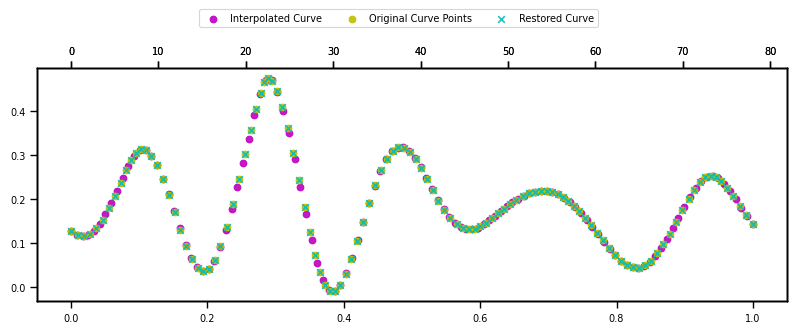

In [75]:
import numpy as np
from scipy.interpolate import interp1d

def parameterize_1d_curve(curve, abscissas):
    """
    Create a function to parameterize a 1D curve with non-uniform abscissas.
    
    :param curve: A 1D numpy array representing the curve's discrete y-values.
    :param abscissas: A 1D numpy array representing the x-values (abscissas) of the curve, should be the same length as `curve`.
    :return: A function that takes a vector of parameter values (t) and returns interpolated points on the curve,
             along with the normalized abscissas (t_values).
    """
    # Normalize abscissas to the range [0, 1] for consistent parameterization
    t_values = (abscissas - abscissas.min()) / (abscissas.max() - abscissas.min())

    # Create an interpolation function for the curve
    interpolate_y = interp1d(t_values, curve, kind='cubic', fill_value="extrapolate")

    def curve_function(t_vector):
        # Clamp t_vector values to be within [0, 1]
        t_vector_clamped = np.clip(t_vector, 0, 1)
        
        # Interpolate y-values at the given t values
        y = interpolate_y(t_vector_clamped)
        return y

    return curve_function, t_values


# Example for reparameterizing curves
reparam_curvatures = []
stored_t_values = []  # Store normalized t_values for each curve
t_vector = np.linspace(0, 1, curvatures.shape[1])  # Parameterization range

for i in range(len(files)):
    curve_func, t_values = parameterize_1d_curve(curvatures[i], abscissas[i])
    stored_t_values.append(t_values)
    interpolated_points = curve_func(t_vector)
    reparam_curvatures.append(interpolated_points)

reparam_curvatures = np.array(reparam_curvatures)


# Function to restore the original curve from reparameterized data
def restore_original_curve(reparam_curve, t_values, abscissas):
    """
    Restore the original curve from the reparameterized data.

    :param reparam_curve: A 1D numpy array representing the reparameterized curve.
    :param t_values: The normalized t_values used during parameterization.
    :param abscissas: The original abscissas used for the curve.
    :return: A 1D numpy array representing the restored curve.
    """
    # Create an interpolation function using the reparameterized curve and t_values
    interpolate_y = interp1d(np.linspace(0, 1, len(reparam_curve)), reparam_curve, kind='cubic', fill_value="extrapolate")

    # Restore the original y-values using the stored t_values
    restored_curve = interpolate_y(t_values)

    return restored_curve


# Restore original curves
restored_curvatures = []
for i in range(len(reparam_curvatures)):
    restored_curve = restore_original_curve(reparam_curvatures[i], stored_t_values[i], abscissas[i])
    restored_curvatures.append(restored_curve)

restored_curvatures = np.array(restored_curvatures)



i = 18
sns.set_context("paper", font_scale=0.8)
fig = plt.figure(figsize=(8, 3))

# 主轴
ax = fig.add_subplot(111)
sc1 = ax.scatter(t_vector, reparam_curvatures[i], color='m', label='Interpolated Curve',alpha=0.9)

# 第二个轴 (共享x轴)
ax2 = ax.twiny()
sc2 = ax2.scatter(abscissas[i], curvatures[i], color='y', label='Original Curve Points',alpha=0.9)

# 第三个轴 (共享x轴)
ax3 = ax.twiny()
sc3 = ax3.scatter(abscissas[i], restored_curvatures[i], color='c', label='Restored Curve',alpha=0.9, marker='x')

# 设置统一的图例
# 通过 handles 和 labels 获取每个轴的图例项
handles, labels = [], []
for ax_item in [ax, ax2, ax3]:
    h, l = ax_item.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# 在整个图的外部设置一个统一的图例
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.show()


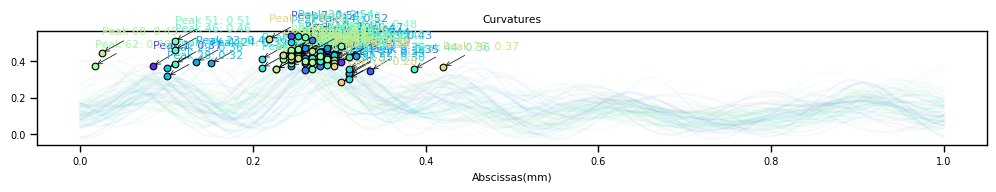

In [76]:

fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(111)
# 遍历每条曲线
for i in range(num_curves):

    # 绘制曲线
    ax1.plot(t_vector, reparam_curvatures[i], color=colors[i], label='curve {}'.format(i), alpha=0.05)

    # 找到最高的峰值及其索引
    max_idx = np.argmax(reparam_curvatures[i])  # 找到最大值索引
    max_value = reparam_curvatures[i][max_idx]  # 最大值

    # 在图中标注最高峰
    ax1.scatter(t_vector[max_idx], max_value, color=colors[i], edgecolor='black', zorder=5)
    ax1.annotate(
        f'Peak {i+1}: {max_value:.2f}',  # 标注文本
        xy=(t_vector[max_idx], max_value),  # 标注位置
        xytext=(t_vector[max_idx], max_value + 0.1),  # 偏移位置
        arrowprops=dict(facecolor=colors[i], arrowstyle='->', lw=0.5),
        fontsize=8,
        color=colors[i]
    )

# 设置标题和标签
ax1.set_title('Curvatures')
ax1.set_xlabel('Abscissas(mm)')

plt.tight_layout()
plt.show()


In [77]:
# !pip install scikit-fda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda import FDataGrid

# curvatures = curve_bs[:,:,2]

# n, k = curvatures.shape
# print (n, k)
# x_grid = np.linspace(0, 1, k)
# x_grid = t_vector.copy()

# fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# # 创建 FisherRaoElasticRegistration 对象
# elastic_registration = FisherRaoElasticRegistration()

# # 执行曲线对齐
# fd_aligned = elastic_registration.fit_transform(fd)

# # 计算对齐后的均值曲线 (Karcher Mean)
# mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]
# print ("mean_function.shape:", mean_function.shape)


# # 将对齐后的曲线数据提取为 numpy array
# aligned_curvatures = fd_aligned.data_matrix[:,:,0]
# print ("aligned_curves.shape:", aligned_curvatures.shape)

# # 提取变形函数
# warping_functions = elastic_registration.warping_.data_matrix[:,:,0]
# print ("warping_functions.shape:", warping_functions.shape)
# elastic_registration.warping_.plot()

In [78]:
from scipy.signal import find_peaks
def find_peaks_and_troughs(reparam_curvature):
    """
    找到以下特定的峰值和谷值索引：
    - 第一个峰值 p1
    - 第一个谷值 t1
    - 第二个峰值 p2
    - 第二个谷值 t2
    - 第三个峰值 p3

    参数:
        reparam_curvature (numpy.ndarray): 一维数组，表示曲线数据。
    
    返回:
        list: [p1, t1, p2, t2, p3]
    """
    peaks, _ = find_peaks(reparam_curvature)  # 找到所有峰值
    troughs, _ = find_peaks(-reparam_curvature)  # 找到所有谷值

    if len(peaks) < 2:
        raise ValueError("The curve does not have enough peaks to meet the criteria.")

    # 确定最高峰值的索引（全局最大值）
    global_max_idx = np.argmax(reparam_curvature[peaks])
    global_max_peak = peaks[global_max_idx]

    # 确定 p1 和 p2
    p1 = None
    p2 = None
    if global_max_idx > 0:  # 最高峰前还有其他峰值
        p2 = global_max_peak
        p1 = peaks[global_max_idx - 1]
    else:  # 最高峰前没有其他峰值
        p1 = global_max_peak
        p2 = peaks[global_max_idx + 1]

    # 确定 p2 后的第三个峰值 p3
    p3_candidates = peaks[peaks > p2]
    if len(p3_candidates) == 0:
        raise ValueError("No peaks found after p2.")
    p3 = p3_candidates[0]  # p3 是 p2 后的第一个峰值

    # 确定 p1 和 p2 之间的谷值 t1
    t1_candidates = troughs[(troughs > p1) & (troughs < p2)]
    if len(t1_candidates) == 0:
        raise ValueError("No troughs found between p1 and p2.")
    t1 = t1_candidates[np.argmin(reparam_curvature[t1_candidates])]

    # 确定 p2 和 p3 之间的谷值 t2
    t2_candidates = troughs[(troughs > p2) & (troughs < p3)]
    if len(t2_candidates) == 0:
        raise ValueError("No troughs found between p2 and p3.")
    t2 = t2_candidates[np.argmin(reparam_curvature[t2_candidates])]

    # 返回结果列表
    result = [p1, t1, p2, t2, p3]

    # 检查结果是否递增
    if not all(x < y for x, y in zip(result, result[1:])):
        raise ValueError(f"The result list is not strictly increasing: {result}")

    return result


landmarks = []
landmarks_120 = []
for i in range(len(reparam_curvatures)):
    # print (i)
    all_indices = find_peaks_and_troughs(reparam_curvatures[i])
    # print ("all_indices:", len(all_indices))
    landmarks.append(all_indices)
    landmarks_120.append(all_indices)

landmarks = np.array(landmarks)/120
landmarks_120 = np.array(landmarks_120)
# print (landmarks)

landmarks是根据reparam_curvatures求的！

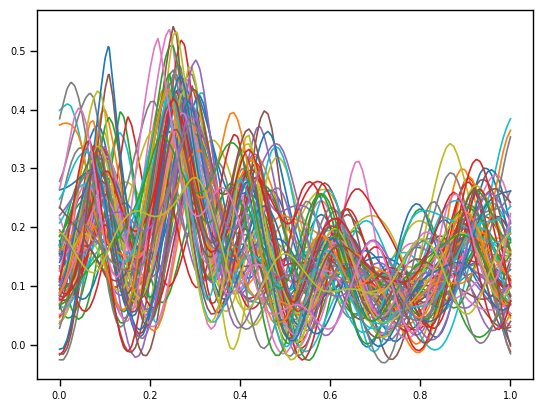

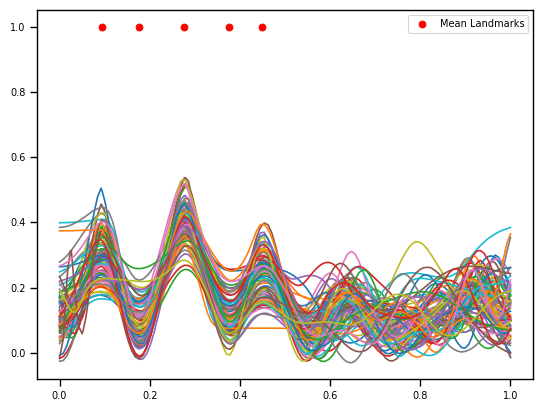

In [79]:
import numpy as np
from skfda.preprocessing.registration import landmark_elastic_registration
from skfda import FDataGrid

x_grid = t_vector.copy()
# print (x_grid)
fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# 使用 landmark_elastic_registration 对齐曲线
fd_registered = landmark_elastic_registration(fd, landmarks)

# 绘制原始曲线
fd.plot(legend=True)

# 绘制对齐后的曲线
fd_registered.plot(legend=True)

# 可选：可视化标志点
plt.scatter(np.mean(landmarks, axis=0), [1] * len(np.mean(landmarks, axis=0)), color='red', label="Mean Landmarks")
plt.legend()
plt.show()

(79, 5)


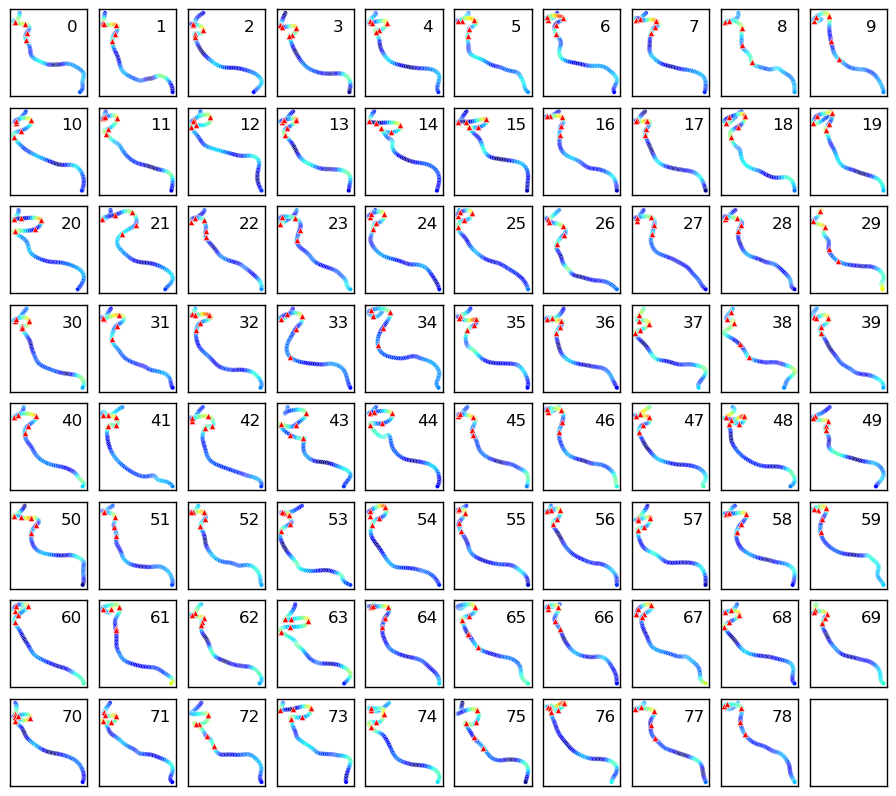

In [80]:
import matplotlib.colors as mcolors

# 创建一个固定范围的归一化对象
norm = mcolors.Normalize(vmin=0, vmax=0.6)

def rotate_curves(curves, angle, axis):
    """
    旋转3D曲线数据集。
    
    :param curves: numpy数组，形状为(n, k, 3)，n是曲线数，k是每条曲线的点数。
    :param angle: 旋转角度，以度为单位。
    :param axis: 旋转轴，'x'、'y'或'z'。
    :return: 旋转后的曲线数据集。
    """
    # 将角度从度转换为弧度
    theta = np.radians(angle)
    
    # 根据轴选择旋转矩阵
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        R = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        R = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # 应用旋转矩阵到每个点
    rotated_curves = np.dot(curves, R.T)
    
    return rotated_curves

ro = rotate_curves(curve_bs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度
int_landmarks = np.array(landmarks*120,dtype=int)
print (int_landmarks.shape)

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=1,s=10, c=reparam_curvatures[i*col+j], cmap='jet',norm=norm)
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j],0], y=ro[i*col+j,int_landmarks[i*col+j],1], ax=ax, alpha=1,s=20, c='red',marker='^')
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.8, 0.8, f'{i*col + j}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


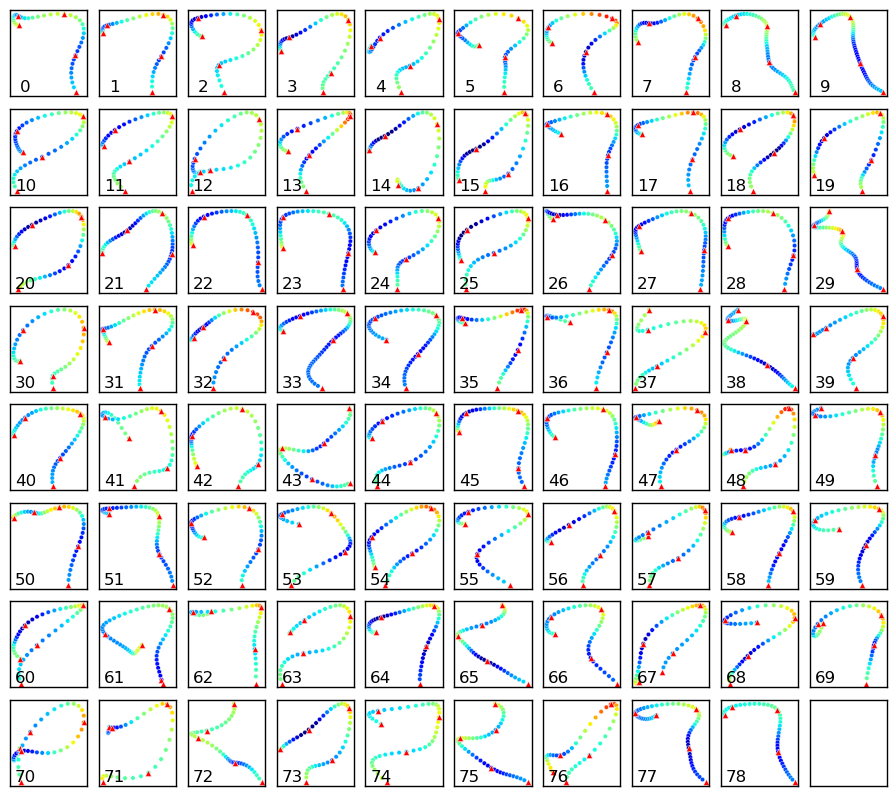

In [81]:

ro = rotate_curves(curve_bs, 60, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

norm = mcolors.Normalize(vmin=0, vmax=0.6)
row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1],0], y=ro[i*col+j,int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1],1], ax=ax, alpha=1,s=10, c=reparam_curvatures[i*col+j][int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1]], cmap='jet',norm=norm)
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j],0], y=ro[i*col+j,int_landmarks[i*col+j],1], ax=ax, alpha=1,s=20, c='red',marker='^')
            # sns.scatterplot(x=ro[i*col+j,trough_indices_reparam[i*col+j],0], y=ro[i*col+j,trough_indices_reparam[i*col+j],1], ax=ax, alpha=1,s=10, c='k')
            
            
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.2, 0.1, f'{i*col + j}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


In [82]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
bad_curve_index = [9, 29,33, 38,43, 44,61,65,67,72,75,76,77]
good_curve_index = [i for i in range(79) if i not in bad_curve_index]
good_curve_index = np.array(good_curve_index)
bad_curve_index = np.array(bad_curve_index)

# good_curvatures = curvatures[good_curve_index]
# bad_curvatures = curvatures[bad_curve_index]
good_curvatures = reparam_curvatures[good_curve_index]
bad_curvatures = reparam_curvatures[bad_curve_index]

good_int_landmarks = int_landmarks[good_curve_index]
bad_int_landmarks = int_landmarks[bad_curve_index]

good_original_centerlines = original_centerlines[good_curve_index]
bad_original_centerlines = original_centerlines[bad_curve_index]

good_normalized_centerlines = curve_bs[good_curve_index]
bad_normalized_centerlines = curve_bs[bad_curve_index]

# good_int_p2 = good_int_landmarks[:,2].reshape(-1,1)
# bad_int_p2 = bad_int_landmarks[:,2].reshape(-1,1)
# print (good_int_landmarks[0])
# print (good_curvatures[0])

def generate_masks(curves, landmarks):
    """
    根据每条曲线的 landmarks 生成掩码。
    掩码标记 p1 到 p2 区间为 1，其他区域为 0。
    
    :param curves: list of numpy arrays，每条曲线的曲率数据。
    :param landmarks: list of numpy arrays，每条曲线的关键点索引 [p1, t1, p2, t2, p3]。
    :return: 掩码矩阵，形状与 curves 相同。
    """
    masks = []
    for curve, landmark in zip(curves, landmarks):
        mask = np.zeros_like(curve, dtype=int)
        p1, p2 = landmark[0], landmark[-1]  # 取出 p1 和 p2 的索引
        mask[p1:p2+1] = 1  # p1 到 p2 的区间标记为 1
        masks.append(mask)
    return np.array(masks)

class CurvatureDataset(Dataset):
    def __init__(self, curves, masks):
        """
        :param curves: 曲率数据，list of numpy arrays。
        :param masks: 掩码数据，list of numpy arrays，表示 p1 到 p2 的区域。
        """
        self.curves = torch.tensor(curves, dtype=torch.float32)
        self.masks = torch.tensor(masks, dtype=torch.long)

    def __len__(self):
        return len(self.curves)

    def __getitem__(self, idx):
        return self.curves[idx], self.masks[idx]



# 生成掩码
# masks = generate_masks(good_curvatures, good_int_landmarks)


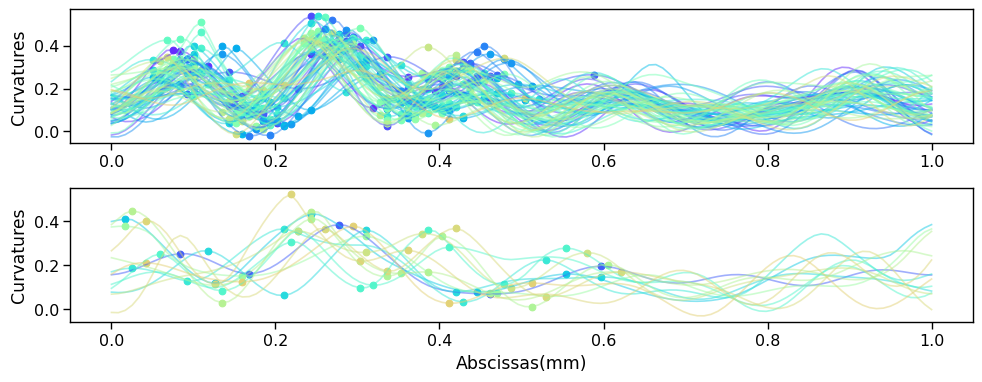

In [83]:
sns.set_context("paper", font_scale=1.3)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# 遍历每条曲线
for i in range(num_curves):
    if i in bad_curve_index:
        x = t_vector[landmarks_120[i]]
        y = reparam_curvatures[i][(landmarks_120[i]).astype(np.int32)]

        ax2.plot(t_vector, reparam_curvatures[i], color=colors[i], label='curve {}'.format(i), alpha=0.5)
        for u in range(len(x)):
            ax2.scatter(x[u], y[u], color=colors[i])
    else:
        x = t_vector[landmarks_120[i]]
        y = reparam_curvatures[i][(landmarks_120[i]).astype(np.int32)]

        ax1.plot(t_vector, reparam_curvatures[i], color=colors[i], label='curve {}'.format(i), alpha=0.5)
        for u in range(len(x)):
            ax1.scatter(x[u], y[u], color=colors[i])

# 设置标题和标签
ax1.set_ylabel('Curvatures')
ax2.set_ylabel('Curvatures')
ax2.set_xlabel('Abscissas(mm)')

plt.tight_layout()
plt.show()


Epoch 1/100, Loss: 0.5001252094904581
Relaxed Boundary Accuracy: 35.51%
Validation Accuracy: 35.51%
Epoch 2/100, Loss: 0.23741517464319864
Relaxed Boundary Accuracy: 36.35%
Validation Accuracy: 36.35%
Epoch 3/100, Loss: 0.10628251234690349
Relaxed Boundary Accuracy: 35.64%
Validation Accuracy: 35.64%
Epoch 4/100, Loss: 0.07930958271026611
Relaxed Boundary Accuracy: 35.19%
Validation Accuracy: 35.19%
Epoch 5/100, Loss: 0.06960409879684448
Relaxed Boundary Accuracy: 35.51%
Validation Accuracy: 35.51%
Epoch 6/100, Loss: 0.06815683841705322
Relaxed Boundary Accuracy: 35.19%
Validation Accuracy: 35.19%
Epoch 7/100, Loss: 0.06772383054097493
Relaxed Boundary Accuracy: 35.51%
Validation Accuracy: 35.51%
Epoch 8/100, Loss: 0.06725269556045532
Relaxed Boundary Accuracy: 35.26%
Validation Accuracy: 35.26%
Epoch 9/100, Loss: 0.06715202331542969
Relaxed Boundary Accuracy: 35.32%
Validation Accuracy: 35.32%
Epoch 10/100, Loss: 0.06694902976353963
Relaxed Boundary Accuracy: 35.51%
Validation Accurac

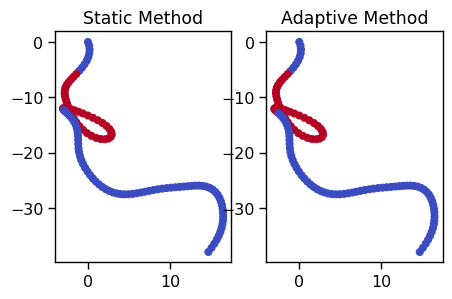

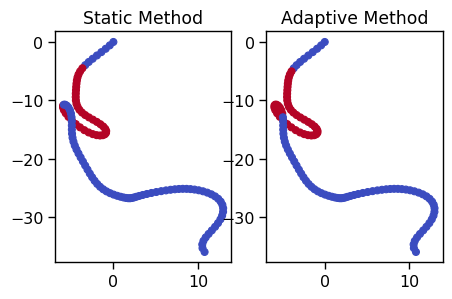

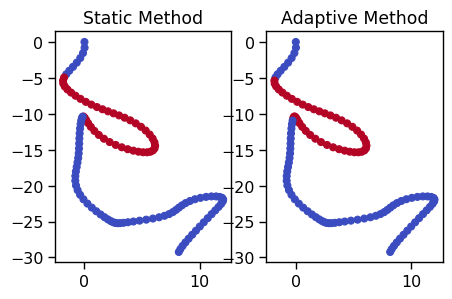

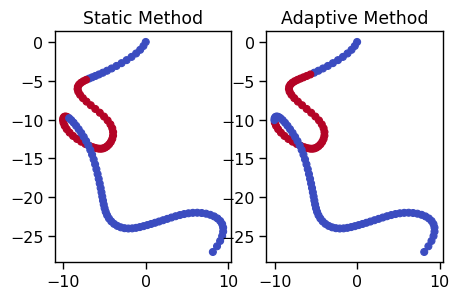

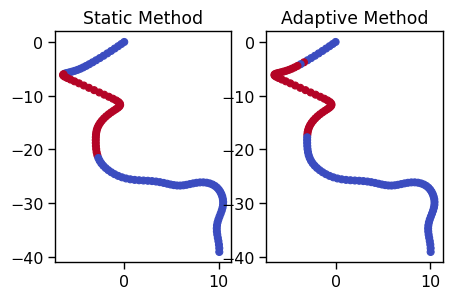

bad cases
Plotting centerlines.


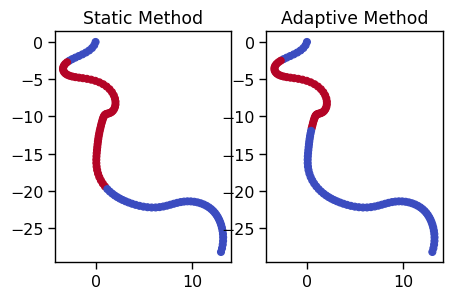

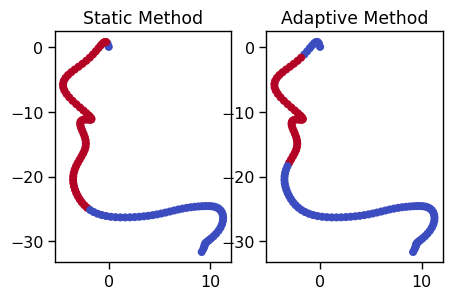

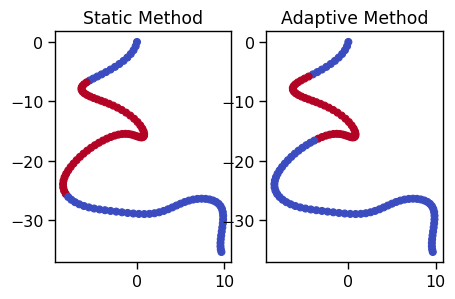

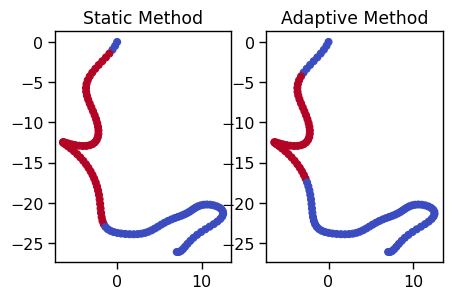

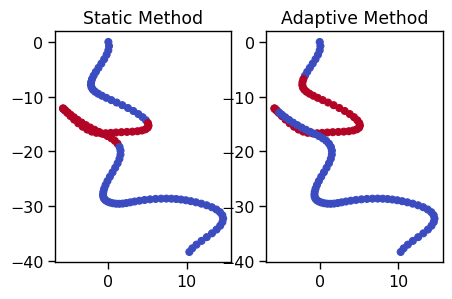

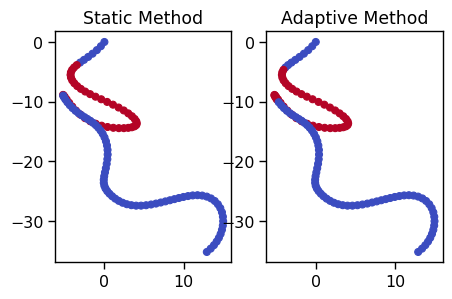

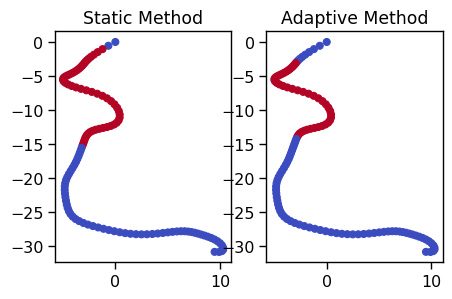

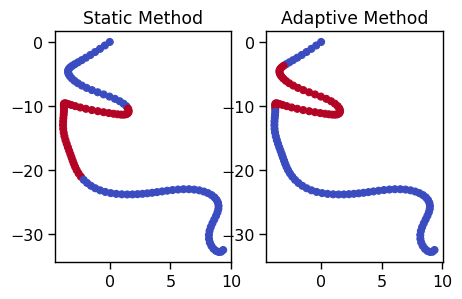

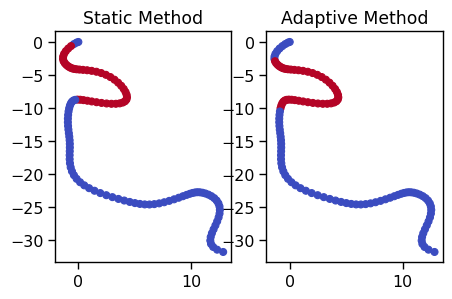

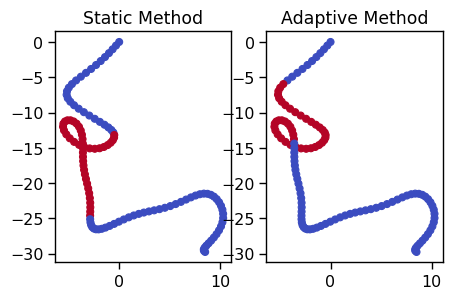

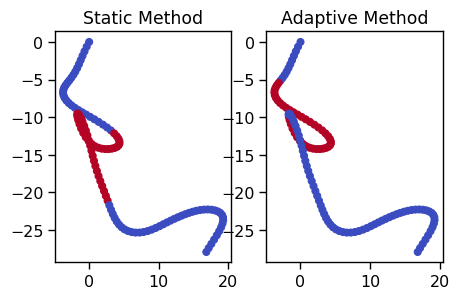

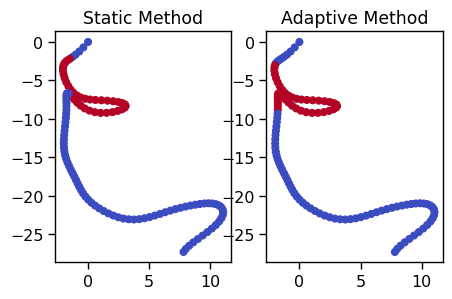

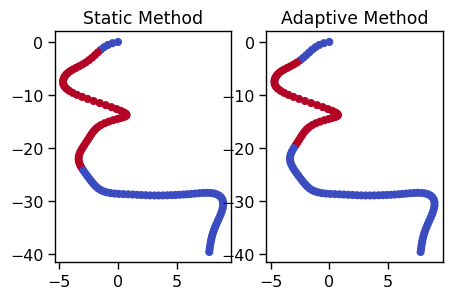

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# 定义 DiceLoss
class DiceLoss(nn.Module):
    def forward(self, outputs, targets):
        """
        :param outputs: 模型输出 [batch_size, num_points, 2]
        :param targets: 真实标签 [batch_size, num_points]
        :return: Dice loss 值
        """
        smooth = 1e-6
        probs = F.softmax(outputs, dim=2)[:, :, 1]  # 获取目标类别的概率
        targets = targets.float()  # 转为浮点型

        intersection = (probs * targets).sum(dim=1)  # 交集
        union = probs.sum(dim=1) + targets.sum(dim=1)  # 并集
        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice_score.mean()

# 定义数据集
class CurvatureDataset(Dataset):
    def __init__(self, curves, masks):
        """
        :param curves: 曲率数据 [num_samples, num_points]
        :param masks: 掩码数据 [num_samples, num_points]
        """
        self.curves = torch.tensor(curves, dtype=torch.float32)
        self.masks = torch.tensor(masks, dtype=torch.long)

    def __len__(self):
        return len(self.curves)

    def __getitem__(self, idx):
        return self.curves[idx], self.masks[idx]

# 划分数据集
def split_dataset(curves, masks, train_ratio=0.8):
    dataset = CurvatureDataset(curves, masks)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return train_loader, test_loader


def create_test_loader(curves, masks, batch_size=16):
    """
    创建一个专门用于测试的 DataLoader，包含所有的曲率数据和掩码数据。
    
    :param curves: 曲率数据 [num_samples, num_points]
    :param masks: 掩码数据 [num_samples, num_points]
    :param batch_size: 测试集的批量大小
    :return: 测试数据的 DataLoader
    """
    # 创建完整的测试数据集
    test_dataset = CurvatureDataset(curves, masks)
    # 创建测试 DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader


# 定义模型
# class LandmarkNet(nn.Module):
#     def __init__(self, input_size, hidden_size=128):
#         super(LandmarkNet, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, input_size * 2)  # 输出 [batch_size, num_points * 2]
#         )

#     def forward(self, x):
#         batch_size, num_points = x.size()
#         out = self.net(x)  # 输出 [batch_size, num_points * 2]
#         out = out.view(batch_size, num_points, 2)  # 调整为 [batch_size, num_points, 2]
#         return out
class LandmarkNet(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(LandmarkNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(input_size * 64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size * 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, num_points]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(x.size(0), -1, 2)



# 训练模型
def train_until_accuracy(
    model, train_loader, test_loader, criterion, optimizer, target_accuracy=0.98, max_epochs=500
):
    train_losses = []
    val_accuracies = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for curves, masks in train_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            loss = criterion(outputs, masks)  # DiceLoss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_losses.append(total_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {train_losses[-1]}")

        # 验证模型
        # accuracy = evaluate(model, test_loader, return_accuracy=True)
        accuracy = evaluate_with_relaxed_boundary(model, test_loader)
        val_accuracies.append(accuracy)
        print(f"Validation Accuracy: {accuracy:.2%}")

        # 提前停止条件
        if accuracy >= target_accuracy:
            print(f"Target accuracy {target_accuracy:.2%} reached. Stopping training.")
            break

    return train_losses, val_accuracies

# # 评估模型
# def evaluate(model, test_loader, return_accuracy=False):
#     model.eval()
#     total_correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for curves, masks in test_loader:
#             outputs = model(curves)  # [batch_size, num_points, 2]
#             _, predicted = torch.max(outputs, dim=2)  # 预测类别 [batch_size, num_points]
#             total_correct += (predicted == masks).sum().item()
#             total_samples += masks.numel()

#     accuracy = total_correct / total_samples
#     if return_accuracy:
#         return accuracy
#     else:
#         print(f"Accuracy: {accuracy:.2%}")
def evaluate_with_relaxed_boundary(model, test_loader, relaxation=2):
    """
    评估模型时对掩码的边界松弛，允许一定范围的误差。
    
    :param model: 已训练的模型
    :param test_loader: 验证数据集 DataLoader
    :param relaxation: 允许的边界松弛范围（± relaxation 个索引）
    :return: Relaxed accuracy
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for curves, masks in test_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            _, predicted = torch.max(outputs, dim=2)  # 每个点的预测类别 [batch_size, num_points]

            # 扩展目标掩码范围
            relaxed_masks = torch.zeros_like(masks)
            for i in range(masks.size(0)):  # 遍历每个样本
                for j in range(masks.size(1)):  # 遍历每个点
                    if masks[i, j] == 1:
                        start = max(0, j - relaxation)
                        end = min(masks.size(1), j + relaxation + 1)
                        relaxed_masks[i, start:end] = 1

            # 比较预测和松弛后的掩码
            total_correct += ((predicted == 1) & (relaxed_masks == 1)).sum().item()
            total_samples += masks.numel()

    accuracy = total_correct / total_samples
    print(f"Relaxed Boundary Accuracy: {accuracy:.2%}")
    return accuracy


def get_validation_predictions(model, test_loader):
    """
    获取测试数据、真实标签和预测结果。
    
    :param model: 已训练的模型。
    :param test_loader: 测试集 DataLoader。
    :return: (all_curvatures, all_masks, all_predictions) - 三者均为 numpy 数组。
    """
    model.eval()
    all_curvatures = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for curves, masks in test_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            _, predicted = torch.max(outputs, dim=2)  # [batch_size, num_points]

            all_curvatures.append(curves.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    # 合并所有批次
    all_curvatures = np.concatenate(all_curvatures, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_curvatures, all_masks, all_predictions

def visualize_predictions(all_curvatures, all_masks, all_predictions, centerlines=[]):
    """
    可视化测试数据、真实标签和预测结果。
    
    :param all_curvatures: 曲率数据，形状为 [num_samples, num_points]。
    :param all_masks: 真实掩码数据，形状为 [num_samples, num_points]。
    :param all_predictions: 预测掩码数据，形状为 [num_samples, num_points]。
    :param centerlines: 可选，曲线中心线数据，默认为空。
    """
    num_samples = len(all_curvatures)


    
    if len(centerlines) == 0:
        print("Plotting lines.")
        for i in range(num_samples):
            plt.figure(figsize=(10, 3))
            plt.plot(all_curvatures[i], label="Curvature", color="blue")
            plt.plot(all_masks[i], label="True Mask", linestyle="--", color="green")
            plt.plot(all_predictions[i], label="Predicted Mask", linestyle="--", color="red")
            plt.title(f"Sample {i}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.legend()
            plt.show()
    else:
        ro = rotate_curves(centerlines, 60, 'x')  # 绕Z轴旋转45度
        ro = rotate_curves(centerlines, 5, 'z')  # 绕Z轴旋转45度
        ro = rotate_curves(centerlines, -15, 'y')  # 绕Z轴旋转45度
        print("Plotting centerlines.")
        for i in range(num_samples):
            fig = plt.figure(figsize=(5, 3))
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            ax1.scatter(ro[i][:, 0], ro[i][:, 1], c=all_masks[i], s=25, cmap='coolwarm')
            ax2.scatter(ro[i][:, 0], ro[i][:, 1], c=all_predictions[i], s=25, cmap='coolwarm')
            ax1.set_title("Static Method")
            ax2.set_title("Adaptive Method")
            plt.show()


# 示例运行
# good_curvatures = good_curvatures  # 曲率数据
normlized_good_curves = (good_curvatures - good_curvatures.mean(axis=1, keepdims=True)) / good_curvatures.std(axis=1, keepdims=True)
normlized_bad_curves = (bad_curvatures - bad_curvatures.mean(axis=1, keepdims=True)) / bad_curvatures.std(axis=1, keepdims=True)

masks = generate_masks(normlized_good_curves, good_int_landmarks)  # 根据地标生成掩码
bad_masks = generate_masks(normlized_bad_curves, bad_int_landmarks)  # 根据地标生成掩码
# 划分数据集
train_loader, valid_loader = split_dataset(normlized_good_curves[:-5], masks[:-5],train_ratio=0.8)
test_loader = create_test_loader(normlized_good_curves[-5:], masks[-5:])
test_centerlines = good_original_centerlines[-5:]
bad_loader = create_test_loader(normlized_bad_curves, bad_masks)
bad_centerlines = bad_original_centerlines

# 初始化模型和优化器
input_size = normlized_good_curves.shape[1]
model = LandmarkNet(input_size=input_size)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
train_losses, val_accuracies = train_until_accuracy(
    model, train_loader, valid_loader, criterion, optimizer, target_accuracy=0.98, max_epochs=100
)

# 可视化验证集结果
# visualize_validation_predictions(model, test_loader, test_centerlines)
# visualize_validation_predictions(model, bad_loader, bad_centerlines)

# 获取验证集结果
all_curvatures, all_masks, all_predictions = get_validation_predictions(model, test_loader)
bad_all_curvatures, bad_all_masks, bad_all_predictions = get_validation_predictions(model, bad_loader)

# 可视化中心线上的分割结果
visualize_predictions(all_curvatures, all_masks, all_predictions, centerlines=test_centerlines)
print ("="*30)
print ("bad cases")
visualize_predictions(bad_all_curvatures, bad_all_masks, bad_all_predictions, centerlines=bad_centerlines)

In [85]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torchviz


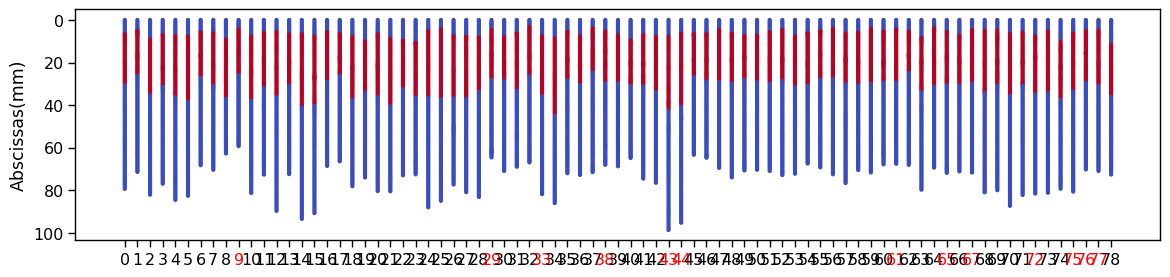

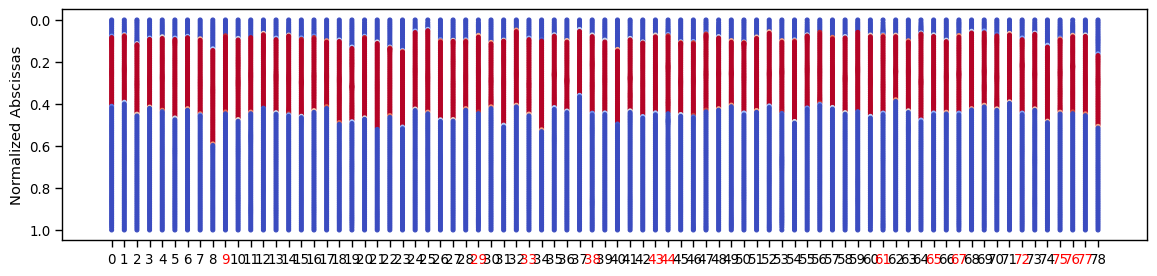

In [86]:
def create_combined_arrays(curvatures, good_indices, bad_indices, 
                           good_curves, good_masks, bad_curves, bad_predictions):
    """
    创建包含 good 和 bad 数据的曲率和掩码数组，保持顺序与 curvatures 一致。
    
    :param curvatures: 原始曲率数组，用于确定最终顺序。
    :param good_indices: good 数据的索引列表。
    :param bad_indices: bad 数据的索引列表。
    :param good_curves: good 数据的曲率数组。
    :param good_masks: good 数据的真实掩码。
    :param bad_curves: bad 数据的曲率数组。
    :param bad_predictions: bad 数据的模型预测掩码。
    :return: new_curvatures, new_masks
    """
    num_samples = curvatures.shape[0]
    new_curvatures = np.zeros_like(curvatures)
    new_masks = np.zeros_like(curvatures)

    # 填充 good 数据
    new_curvatures[good_indices] = good_curves
    new_masks[good_indices] = good_masks

    # 填充 bad 数据
    new_curvatures[bad_indices] = bad_curves
    new_masks[bad_indices] = bad_predictions

    return new_curvatures, new_masks


# 获取 bad 数据的预测标签
bad_predictions = bad_all_predictions  # 来自模型的预测结果

# 创建 new_curvatures 和 new_masks
new_curvatures, new_masks = create_combined_arrays(
    curvatures=curvatures,
    good_indices=good_curve_index,
    bad_indices=bad_curve_index,
    good_curves=good_curvatures,
    good_masks=masks,
    bad_curves=bad_curvatures,
    bad_predictions=bad_predictions
)

def has_single_one_region(mask):
    """
    检测 1D 数列中是否只有一个连续的 1 区域。

    :param mask: 1D numpy 数组，元素为 0 或 1。
    :return: True 如果只有一个连续的 1 区域，否则为 False。
    """
    # 差分操作，找出 1 的起点和终点
    diff = np.diff(mask, prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    # 如果起点和终点只对应一个区域，返回 True
    return len(starts) == 1 and len(ends) == 1

# for i in range(len(new_masks)):
#     print ("i", has_single_one_region(new_masks[i]))

# 标准化每个 abscissas[i] 并调整对应的 new_masks[i]
normalized_abscissas = []
rescaled_masks = []
rescaled_curvatures = [] 

for i in range(len(abscissas)):
    # 标准化 abscissas[i] 到 [0, 1]
    min_val = abscissas[i].min()
    max_val = abscissas[i].max()
    norm_abscissa = (abscissas[i] - min_val) / (max_val - min_val)
    normalized_abscissas.append(norm_abscissa)

    # 压缩或拉伸 new_masks[i] 到与 norm_abscissa 的比例一致
    interp_mask = np.interp(norm_abscissa, np.linspace(0, 1, len(new_masks[i])), new_masks[i])
    rescaled_masks.append(interp_mask)
    rescaled_curvatures.append(np.interp(norm_abscissa, np.linspace(0, 1, len(new_masks[i])), new_curvatures[i]))

normalized_abscissas = np.array(normalized_abscissas, dtype=object)
rescaled_masks = np.array(rescaled_masks, dtype=object)
rescaled_curvatures = np.array(rescaled_curvatures, dtype=object)

fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(111)
for i in range(len(reparam_curvatures)):
    ax1.scatter(np.ones(reparam_curvatures[i].shape)*i, abscissas[i], c=new_masks[i], s=5, cmap='coolwarm')
# ax1.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
ax1.set_xticks(range(len(reparam_curvatures)))  # 设置 xtick 的位置
ax1.set_xticklabels(range(len(reparam_curvatures)))  # 设置 xtick 的标签为数字
# ax1.autoscale(enable=True, axis='x', tight=True)
# ax1.autoscale(enable=True, axis='y', tight=True)
ax1.set_ylabel('Abscissas(mm)')
ax1.invert_yaxis()
for tick, index in zip(ax1.get_xticklabels(), range(len(reparam_curvatures))):
    if index in bad_curve_index:
        tick.set_color('red')
plt.show()
sns.set_context("paper", font_scale=1.1)
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(111)

for i in range(len(reparam_curvatures)):
    ax1.scatter(
        np.ones(normalized_abscissas[i].shape) * i,
        normalized_abscissas[i],
        c=rescaled_masks[i],
        s=8,
        cmap='coolwarm'
    )


# ax1.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串

ax1.set_xticks(range(len(reparam_curvatures)))  # 设置 xtick 的位置
ax1.set_xticklabels(range(len(reparam_curvatures)))  # 设置 xtick 的标签为数字
ax1.invert_yaxis()
# ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Normalized Abscissas')
# 修改 bad_curve_index 中 xtick 的颜色为红色
for tick, index in zip(ax1.get_xticklabels(), range(len(reparam_curvatures))):
    if index in bad_curve_index:
        tick.set_color('red')
plt.show()


## To-Do: Peak位置应当记录在abscissas上的位置，而不是在横轴上的

(79, 5)


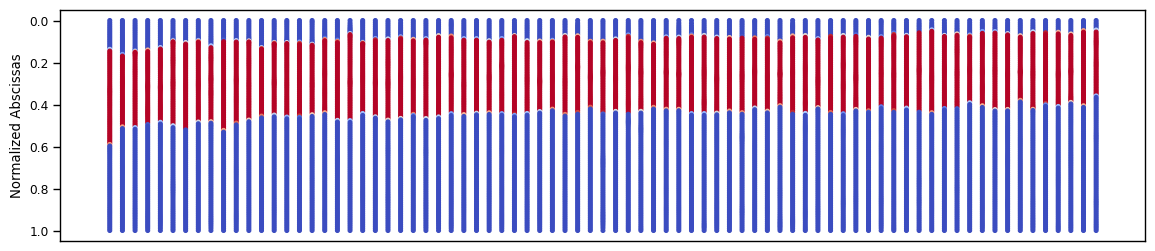

In [87]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(rescaled_masks)
print(pca_result.shape)


# 获取按照 pca_result[:,0] 排序的索引
sorted_indices = np.argsort(-pca_result[:, 0])  # 从大到小排序

# 重新排序数据
sorted_abscissas = [normalized_abscissas[i] for i in sorted_indices]
sorted_rescaled_masks = [rescaled_masks[i] for i in sorted_indices]
sorted_rescaled_curvatures = [rescaled_curvatures[i] for i in sorted_indices]
sorted_curvature_peaks = []
# 绘制图形

sns.set_context("paper", font_scale=1.0)
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(111)

for i, idx in enumerate(sorted_indices):  # 按排序后的索引绘制
    ax1.scatter(
        np.ones(sorted_abscissas[i].shape) * i,  # 使用新的 x 顺序
        sorted_abscissas[i],
        c=sorted_rescaled_masks[i],
        s=8,
        cmap='coolwarm'
    )

# 设置 xticks 和 xticklabels，保持原来的数据索引
ax1.set_xticks(range(len(reparam_curvatures)))
ax1.set_xticklabels(sorted_indices)  # 显示排序后的索引

# ax2: bar chart
for i, idx in enumerate(sorted_indices):  # 按排序后的索引绘制
    mask = sorted_rescaled_masks[i]
    curve = sorted_rescaled_curvatures[i]
    
    # # 找到第一个为 1 的位置
    # first_one = np.where(mask == 1)[0][0] if 1 in mask else 0
    
    # # 找到最后一个为 1 的位置
    # last_one = np.where(mask == 1)[0][-1] if 1 in mask else 0
    
    # # 找到连续 1 序列的中点
    # if first_one < last_one:
    #     midpoint = (first_one + last_one) / 2
    # else:
    #     midpoint = 0  # 如果没有连续 1，则中点为 0
    # curv_peak = np.argmax(mask[25:-25]*curve[25:-25])+25
    # ax1.scatter(i, midpoint/len(reparam_curvatures[0]), color='white', s=20, marker="d", edgecolors='k')  # 绘制中点
    # ax1.scatter(i, curv_peak/len(reparam_curvatures[0]), color='k', s=20, marker="d", edgecolors='w')  # 绘制中点
    # sorted_curvature_peaks.append(curv_peak/len(reparam_curvatures[0]))

    # # 绘制三个 bar
    # ax2.bar(i - 0.2, first_one, width=0.2, color='blue', label='First 1' if i == 0 else "")
    # ax2.bar(i, last_one, width=0.2, color='green', label='Last 1' if i == 0 else "")
    # ax2.bar(i + 0.2, midpoint, width=0.2, color='red', label='Midpoint' if i == 0 else "")

# 添加图例
# ax2.legend()
# ax2.set_xticks(range(len(reparam_curvatures)))
# ax2.set_xticklabels(sorted_indices)  # 显示排序后的索引

# 修改 bad_curve_index 中 xtick 的颜色为红色
for tick, index in zip(ax1.get_xticklabels(), sorted_indices):
    if index in bad_curve_index:
        tick.set_color('red')

# ax1: 设置 y 轴和方向
ax1.invert_yaxis()
ax1.set_ylabel('Normalized Abscissas')
ax1.set_xticks([])

plt.show()
# sorted_curvature_peaks = np.array(sorted_curvature_peaks)

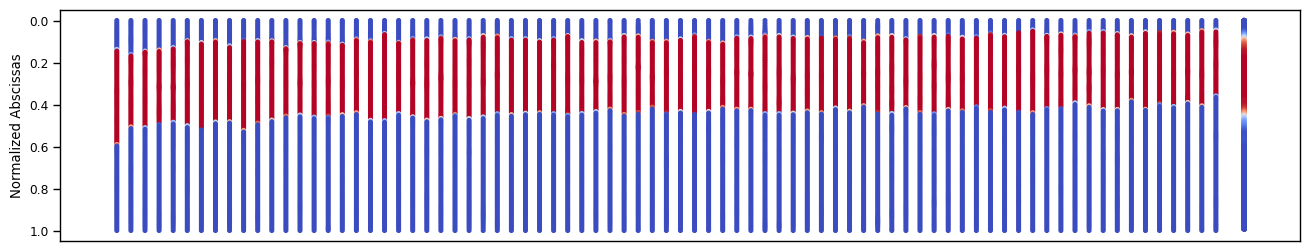

In [88]:
fig = plt.figure(figsize=(16, 3))  # 增大宽度以容纳新的scatter列
ax1 = fig.add_subplot(111)

for i, idx in enumerate(sorted_indices):  # 按排序后的索引绘制
    ax1.scatter(
        np.ones(sorted_abscissas[i].shape) * i,  # 使用新的 x 顺序
        sorted_abscissas[i],
        c=sorted_rescaled_masks[i],
        s=8,
        cmap='coolwarm'
    )

# 在最右边绘制概率分布
n, m = np.array(sorted_rescaled_masks).shape
for i, idx in enumerate(sorted_indices):
    # 计算每一行的概率分布（即对每一列求和并除以n）
    column_probabilities = np.sum(sorted_rescaled_masks, axis=0) / n
    x_positions = np.ones(m) * (n + 1)  # 将新的scatter绘制在n+1位置
    ax1.scatter(
        x_positions,  # x轴位置
        np.arange(m)/m,  # y轴位置
        c=column_probabilities,  # 使用概率分布作为颜色
        s=8,
        cmap='coolwarm'
    )
ax1.invert_yaxis()
ax1.set_ylabel('Normalized Abscissas')
ax1.set_xticks([])

plt.show()


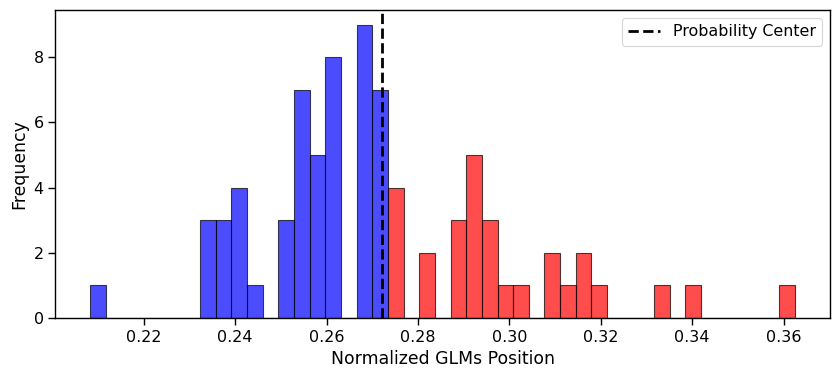

subsequence_positions: [0.3625     0.34166667 0.33333333 0.32083333 0.31666667 0.3125
 0.31666667 0.30833333 0.30416667 0.30833333 0.29583333 0.29583333
 0.3        0.29583333 0.29166667 0.29166667 0.29166667 0.2875
 0.2875     0.29166667 0.29166667 0.2875     0.28333333 0.28333333
 0.275      0.275      0.275      0.275      0.27083333 0.27083333
 0.27083333 0.27083333 0.26666667 0.27083333 0.27083333 0.27083333
 0.26666667 0.26666667 0.26666667 0.26666667 0.26666667 0.26666667
 0.26666667 0.2625     0.2625     0.2625     0.26666667 0.2625
 0.2625     0.2625     0.25833333 0.2625     0.2625     0.25416667
 0.25833333 0.25833333 0.25416667 0.25833333 0.25833333 0.25416667
 0.25416667 0.25416667 0.25416667 0.25416667 0.25       0.24166667
 0.25       0.25       0.24583333 0.24166667 0.24166667 0.24166667
 0.23333333 0.2375     0.2375     0.2375     0.23333333 0.23333333
 0.20833333]
front_or_back_indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 

In [89]:
# === 1. 计算每一条数据的子序列位置（取中位数位置） ===
subsequence_positions = []
for i in range(n):
    mask = sorted_rescaled_masks[i]
    if np.sum(mask) > 0:
        positions = np.where(mask == 1)[0]
        position_center = positions.mean() / m  # 归一化位置 (0到1)
    else:
        position_center = 0  # 如果没有子序列，设置位置为0
    subsequence_positions.append(position_center)

subsequence_positions = np.array(subsequence_positions)  # (n,)

# === 2. 计算概率分布的位置（每列中1的数量除以n，得到概率分布） ===
column_probabilities = np.sum(sorted_rescaled_masks, axis=0) / n
probability_position = np.sum(np.arange(m) * column_probabilities) / np.sum(column_probabilities)
normalized_probability_position = probability_position / m  # 归一化到 0-1 之间

# === 3. 计算 front_or_back_indices (定义每个样本是靠前 (1) 还是靠后 (0)) ===
front_or_back_indices = (subsequence_positions < normalized_probability_position).astype(int)

# === 4. 绘制直方图，比较每条数据的位置与概率分布的位置 ===
sns.set_context("paper", font_scale=1.3)
plt.figure(figsize=(10, 4))

# 绘制子序列位置的直方图
n_bins = 45  # 直方图的分箱数量
counts, bins, patches = plt.hist(subsequence_positions, bins=n_bins, color='gray', edgecolor='black', alpha=0.7)

# 重新根据 bins 判断每个 subsequence_position 落在哪个 bin 中
bin_indices = np.digitize(subsequence_positions, bins) - 1  # digitize 返回的索引是 1-indexed
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # 计算每个 bin 的中心

# 为直方图的每个 bin 着色：蓝色表示靠前，红色表示靠后
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2  # 当前 bin 的中心位置
    if bin_center < normalized_probability_position:
        patch.set_facecolor('blue')  # 蓝色表示比概率分布靠前
    else:
        patch.set_facecolor('red')  # 红色表示比概率分布靠后

# 绘制概率分布位置的垂直线
plt.axvline(x=normalized_probability_position, color='black', linestyle='--', linewidth=2, label='Probability Center')

# 图形设置
plt.xlabel('Normalized GLMs Position')
plt.ylabel('Frequency')
# plt.title('Distribution of Subsequence Positions')
plt.legend()
plt.show()

# 调试信息，打印每个数据的子序列位置、其对应的 bin、是否靠前(1)还是靠后(0)
print("subsequence_positions:", subsequence_positions)
print("front_or_back_indices:", front_or_back_indices)



In [90]:
import numpy as np
from scipy.interpolate import interp1d

def extract_and_interpolate(sorted_curve_bs, sorted_rescaled_masks, target_points=50):
    """
    提取 sorted_curve_bs 中 mask 为 1 的连续曲线，并将其插值为目标数量的 3D 点。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    sorted_rescaled_masks (ndarray): 形状为 (n, m) 的二进制掩码，1 表示保留的位置，0 表示丢弃的位置。
    target_points (int): 插值后的目标点数，默认值为 50。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 120, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 50, 3)
    
    for i in range(n):
        mask = sorted_rescaled_masks[i]  # 形状为 (m,)
        
        # 找到 mask == 1 的连续位置的索引
        indices = np.where(mask == 1)[0]
        
        if len(indices) > 0:
            # 提取连续的曲线段
            start_index = indices[0]
            end_index = indices[-1] + 1  # 包含最后一个索引
            extracted_curve = sorted_curve_bs[i, start_index:end_index, :]  # 形状为 (p, 3)
            
            # 如果提取的曲线点太少，无法插值，则跳过
            if extracted_curve.shape[0] > 1:
                original_points = np.linspace(0, 1, extracted_curve.shape[0])  # 原始曲线的归一化位置
                target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
                
                for j in range(d):  # 对 x, y, z 维度分别进行插值
                    interpolator = interp1d(original_points, extracted_curve[:, j], kind='linear', fill_value="extrapolate")
                    interpolated_data[i, :, j] = interpolator(target_indices)  # 插值后的曲线
            else:
                # 如果无法提取出至少2个点，则用 0 填充该曲线的插值结果
                interpolated_data[i, :, :] = 0
        else:
            # 如果 mask 中没有 1，则用 0 填充该曲线的插值结果
            interpolated_data[i, :, :] = 0

    return interpolated_data



(79, 120, 3)
(79, 50, 3)
(79, 50)


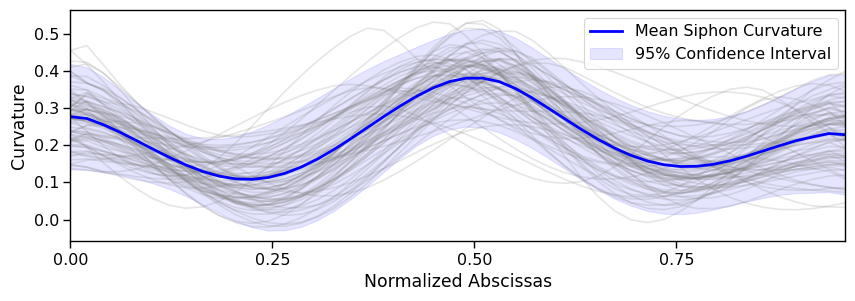

In [91]:
import numpy as np
from scipy.interpolate import interp1d

def parameterize_1d_curve(curve, abscissas):
    """
    Create a function to parameterize a 1D curve with non-uniform abscissas.
    
    :param curve: A 1D numpy array representing the curve's discrete y-values.
    :param abscissas: A 1D numpy array representing the x-values (abscissas) of the curve, should be the same length as `curve`.
    :return: A function that takes a vector of parameter values (t) and returns interpolated points on the curve,
             along with the normalized abscissas (t_values).
    """
    if len(curve) == 0 or len(abscissas) == 0:
        # 返回全零函数和空的t_values
        def empty_curve_function(t_vector):
            return np.zeros_like(t_vector)
        return empty_curve_function, np.zeros_like(abscissas)
    
    # 将abscissas和curve转换为浮点类型，防止整数类型或布尔类型
    curve = np.asarray(curve, dtype=float)
    abscissas = np.asarray(abscissas, dtype=float)

    # Normalize abscissas to the range [0, 1] for consistent parameterization
    abscissa_range = abscissas.max() - abscissas.min()
    if abscissa_range == 0:  # 防止除以零
        t_values = np.zeros_like(abscissas)
    else:
        t_values = (abscissas - abscissas.min()) / abscissa_range

    # Create an interpolation function for the curve
    interpolate_y = interp1d(t_values, curve, kind='cubic', fill_value="extrapolate")

    def curve_function(t_vector):
        # Clamp t_vector values to be within [0, 1]
        t_vector_clamped = np.clip(t_vector, 0, 1)
        
        # Interpolate y-values at the given t values
        y = interpolate_y(t_vector_clamped)
        return y

    return curve_function, t_values


def extract_and_parameterize_subsequences(sorted_rescaled_masks, sorted_siphon_curvatures, sorted_abscissas, num_points=50):
    """
    Extract non-zero subsequences from each sequence, parameterize them to have uniform length.

    :param sorted_rescaled_masks: (n, m) array, masks indicating where the subsequence is present.
    :param sorted_siphon_curvatures: (n, m) array, the values of the siphon curvatures.
    :param sorted_abscissas: (n, m) array, the abscissas corresponding to each value.
    :param num_points: The number of points to parameterize each subsequence.
    :return: A numpy array of shape (n, num_points), each row being the parameterized subsequence.
    """
    n, m = sorted_rescaled_masks.shape
    parameterized_subsequences = []

    for i in range(n):
        # Extract non-zero subsequence for the current sequence
        mask = sorted_rescaled_masks[i] > 0
        if np.sum(mask) == 0:  # 如果mask中没有1，直接返回0
            parameterized_subsequences.append(np.zeros(num_points))
            continue
        
        # Extract corresponding values and abscissas
        curvatures = sorted_siphon_curvatures[i][mask]
        abscissas = sorted_abscissas[i][mask]
        
        # Create a parameterization function for this subsequence
        curve_function, _ = parameterize_1d_curve(curvatures, abscissas)
        
        # Parameterize to `num_points` uniformly spaced points in the range [0, 1]
        t_vector = np.linspace(0, 1, num_points)
        parameterized_curve = curve_function(t_vector)
        
        # 防止parameterized_curve是NaN（如果出错则填充0）
        if np.isnan(parameterized_curve).any():
            parameterized_curve = np.zeros(num_points)
        
        parameterized_subsequences.append(parameterized_curve)

    return np.array(parameterized_subsequences)


sorted_curve_bs = [curve_bs[i] for i in sorted_indices]
sorted_curve_bs = np.array(sorted_curve_bs)
print (sorted_curve_bs.shape)

# 计算siphon curvature


sorted_rescaled_curvatures = np.array(sorted_rescaled_curvatures)
sorted_rescaled_masks = np.array(sorted_rescaled_masks)
sorted_siphon_curvatures = sorted_rescaled_curvatures * sorted_rescaled_masks
sorted_siphon_centerlines = extract_and_interpolate(sorted_curve_bs, sorted_rescaled_masks, target_points=50)
print (sorted_siphon_centerlines.shape)
n_point = 50

# 提取并重新参数化每个子序列到固定长度 50
result = extract_and_parameterize_subsequences(sorted_rescaled_masks, sorted_siphon_curvatures, sorted_abscissas, num_points=n_point)
print(result.shape)
result = result[:,1:-1]


# === 1. 计算子序列的平均形状 ===
mean_curve = np.mean(result, axis=0)  # 计算均值曲线
std_curve = np.std(result, axis=0)    # 计算标准差曲线

# === 2. 计算概率分布曲线 ===
# 归一化每一列，得到概率分布
column_sums = np.sum(result, axis=0, keepdims=True)  # 每一列的总和
probability_distribution = result / column_sums  # 归一化每一列
num_points = sorted_siphon_curvatures
# === 3. 可视化 ===
# 绘制平均形状和置信区间
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
for i in range(len(result)):
    plt.plot(result[i], color='gray', alpha=0.2)
ax.plot(mean_curve, label='Mean Siphon Curvature', color='blue', linewidth=2)
ax.fill_between(
    np.arange(result.shape[1]),
    mean_curve - 1.96 * std_curve,
    mean_curve + 1.96 * std_curve,
    color='blue',
    alpha=0.1,
    label='95% Confidence Interval'
)
ax.set_xlabel('Normalized Abscissas')
ax.set_ylabel('Curvature')
set_x_ticks_normalized(ax, range(n_point))
# plt.title('Mean Shape and 95% Confidence Interval')
plt.legend()
plt.show()




(119, 3)
(79, 119, 3)


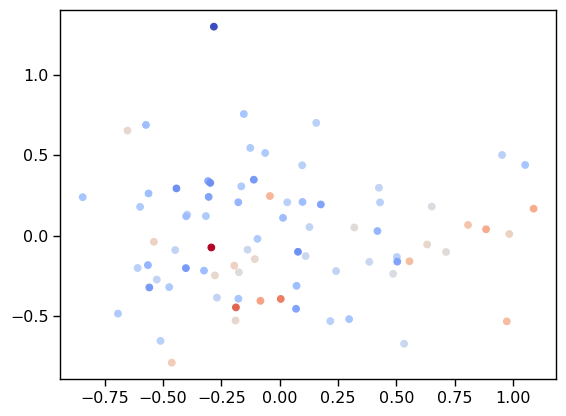

In [99]:
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.fiber_bundle import FiberBundle
from geomstats.geometry.quotient_metric import QuotientMetric

def move_curves_to_origin(curves):
    c = []
    for i in range(curves.shape[0]):
        c.append(curves[i] - curves[i][0])
    return np.array(c)

# 1️⃣ 移动每条曲线到原点
curve_bs1 = move_curves_to_origin(curve_bs)
curve_bs1 = curve_bs1[:,1:,:]
sorted_curve_bs1 = curve_bs1[sorted_indices]
sorted_files = [files[i] for i in sorted_indices]


# 2️⃣ 定义离散曲线流形
k_sampling_points = 120
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

# 3️⃣ 配置 SRVMetric
curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()




tPCA_N_COMPONENTS = 5

# 4️⃣ 计算 Frechet 均值
mean = FrechetMean(curves_r3)
mean.fit(sorted_curve_bs1)
mean_estimate = mean.estimate_
tangent_base = mean.estimate_

print(mean_estimate.shape)
print(sorted_curve_bs1.shape)

# 5️⃣ 计算 TangentPCA
tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(sorted_curve_bs1, base_point=tangent_base)
tangent_projected_data = tpca.transform(sorted_curve_bs1)

plt.scatter(tangent_projected_data[:, 0], tangent_projected_data[:, 1],c=subsequence_positions,cmap='coolwarm')


In [93]:
# !pip install --upgrade geomstats

In [94]:
def generate_vtk_with_curves(filename, points, curve_bs, attribute_names, attributes):
    """
    生成包含点和对应曲线的VTK文件，确保每个曲线的中心落在对应的点上
    :param filename: 输出的VTK文件名
    :param points: 点的坐标列表
    :param curve_bs: 曲线的坐标列表，每个点对应一条曲线
    :param attribute_names: 属性名称列表
    :param attributes: 属性值列表
    """
    with open(filename, 'w') as file:
        file.write("# vtk DataFile Version 3.0\n")
        file.write("tangent_project_data\n")
        file.write("ASCII\n")
        file.write("DATASET POLYDATA\n")

        total_points = len(points) * len(curve_bs[0])
        file.write(f"POINTS {total_points} float\n")

        for i, point in enumerate(points):
            curve = curve_bs[i]
            curve_center = np.mean(curve, axis=0)
            adjusted_curve = curve - curve_center + point
            for c in adjusted_curve:
                file.write(f"{c[0]} {c[1]} {c[2]}\n")

        total_lines = len(points)
        line_size = len(curve_bs[0])
        file.write(f"LINES {total_lines} {total_lines * (1 + line_size)}\n")
        
        for i in range(len(points)):
            file.write(f"{line_size}")
            for j in range(line_size):
                file.write(f" {i * line_size + j}")
            file.write("\n")

        file.write(f"CELL_DATA {total_lines}\n")
        for i, name in enumerate(attribute_names):
            file.write(f"SCALARS {name} float 1\n")
            file.write("LOOKUP_TABLE default\n")
            for attribute in attributes:
                file.write(f"{attribute[i]}\n")

points = tangent_projected_data[:, :3]

source = np.zeros(len(curve_bs))
print (source.shape)
source[79:] = 1

# U: BG11_Left V: Bh0031_Left C: Bh0006_Left
filenames = ['BH0006_ICA_L','BH0039_ICA_L','BG0011_ICA_L','BH0031_ICA_L'] # ,'BH0035_ICA_L'
mark = 1

t_project_data = []
for i in range(len(sorted_files)):
    n = sorted_files[i].split('\\')[-1].split('.')[0]
    if n in filenames:
        print (mark, n)
        source[i] = mark
        t_project_data.append(tangent_projected_data[i])
        mark += 1
    else:
        source[i] = -1


attributes = np.vstack([source]).T
attribute_names = ["source"]

ro = rotate_curves(sorted_curve_bs1, 135, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 90, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

generate_vtk_with_curves('tangent_project_data_v4.vtk', points, ro, attribute_names, attributes)
#  BH0035_ICA_L BH0006_ICA_L




(79,)
1 BH0006_ICA_L
2 BH0039_ICA_L
3 BH0031_ICA_L
4 BG0011_ICA_L


In [95]:
from scipy.stats import norm


def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves


def save_vtk_text(filename, all_points, num_components, component_values):
    with open(filename, 'w') as f:
        # Write the header
        f.write("# vtk DataFile Version 2.0\n")
        f.write("3D curve data\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        # Write the points
        total_points = sum(len(points) for points in all_points)
        f.write(f"POINTS {total_points} float\n")
        point_offset = 0
        for points in all_points:
            for point in points:
                f.write(f"{point[0]} {point[1]} {point[2]}\n")

        # Write the lines
        f.write(f"LINES {num_components} {total_points + num_components}\n")
        point_index = 0
        for points in all_points:
            f.write(f"{len(points)} ")
            for i in range(len(points)):
                f.write(f"{point_index + i} ")
            f.write("\n")
            point_index += len(points)
        # Write the cell data
        f.write(f"CELL_DATA {num_components}\n")
        f.write("SCALARS ComponentValue float 1\n")
        f.write("LOOKUP_TABLE default\n")
        for value in component_values:
            f.write(f"{value+1}\n")
            
discrete_curves_space = curves_r3

In [96]:
t_project_data = np.array(t_project_data)
print (t_project_data.shape)

# 准备存放结果的列表
interpolated_arrays = []

# 在 t_project_data 的相邻行之间进行插值
for i in range(len(t_project_data) - 1):
    # 从第 i 行插值到第 i+1 行，num=5 表示插值点为 5 个
    arr = np.linspace(t_project_data[i], t_project_data[i+1], num=5, axis=0)
    interpolated_arrays.append(arr)

# interpolated_arrays[0] 对应从第 1 行渐变到第 2 行
# interpolated_arrays[1] 对应从第 2 行渐变到第 3 行
# interpolated_arrays[2] 对应从第 3 行渐变到第 4 行

# 打印结果
for idx, arr in enumerate(interpolated_arrays):
    print(f"Interpolated array {idx+1}:")
    print(arr, "\n")

(4, 5)
Interpolated array 1:
[[-4.16504867e-02  2.46806645e-01  2.26800536e-01  1.66708309e-01
   9.40210276e-02]
 [ 1.70495012e-01  2.01879560e-01  2.51192313e-01  1.11085303e-01
   9.25147710e-02]
 [ 3.82640510e-01  1.56952476e-01  2.75584091e-01  5.54622977e-02
   9.10085143e-02]
 [ 5.94786008e-01  1.12025391e-01  2.99975869e-01 -1.60707727e-04
   8.95022577e-02]
 [ 8.06931507e-01  6.70983067e-02  3.24367647e-01 -5.57837132e-02
   8.79960010e-02]] 

Interpolated array 2:
[[ 0.80693151  0.06709831  0.32436765 -0.05578371  0.087996  ]
 [ 0.55798946 -0.08117399  0.18374887  0.0141222   0.07705393]
 [ 0.30904742 -0.2294463   0.0431301   0.0840281   0.06611186]
 [ 0.06010538 -0.3777186  -0.09748867  0.15393401  0.05516978]
 [-0.18883666 -0.5259909  -0.23810745  0.22383992  0.04422771]] 

Interpolated array 3:
[[-0.18883666 -0.5259909  -0.23810745  0.22383992  0.04422771]
 [-0.01609479 -0.42743647 -0.24678417  0.11952252 -0.03410806]
 [ 0.15664708 -0.32888204 -0.25546089  0.01520513 -0.11

[-0.04165049  0.24680665  0.22680054  0.16670831  0.09402103]
--
[0.17049501 0.20187956 0.25119231 0.1110853  0.09251477]
--
[0.38264051 0.15695248 0.27558409 0.0554623  0.09100851]
--
[ 5.94786008e-01  1.12025391e-01  2.99975869e-01 -1.60707727e-04
  8.95022577e-02]
--
[ 0.80693151  0.06709831  0.32436765 -0.05578371  0.087996  ]
--
[ 0.80693151  0.06709831  0.32436765 -0.05578371  0.087996  ]
--
[ 0.55798946 -0.08117399  0.18374887  0.0141222   0.07705393]
--
[ 0.30904742 -0.2294463   0.0431301   0.0840281   0.06611186]
--
[ 0.06010538 -0.3777186  -0.09748867  0.15393401  0.05516978]
--
[-0.18883666 -0.5259909  -0.23810745  0.22383992  0.04422771]
--
[-0.18883666 -0.5259909  -0.23810745  0.22383992  0.04422771]
--
[-0.01609479 -0.42743647 -0.24678417  0.11952252 -0.03410806]
--
[ 0.15664708 -0.32888204 -0.25546089  0.01520513 -0.11244383]
--
[ 0.32938895 -0.23032761 -0.26413761 -0.08911227 -0.1907796 ]
--
[ 0.50213082 -0.13177317 -0.27281433 -0.19342967 -0.26911537]
--



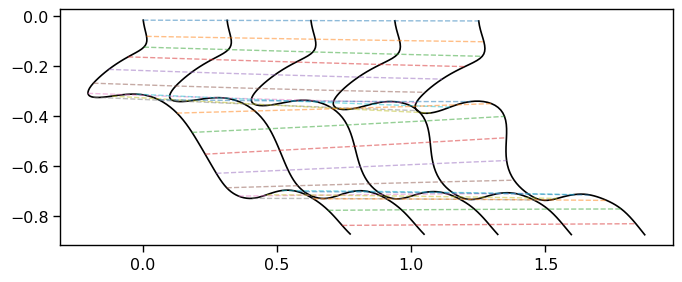

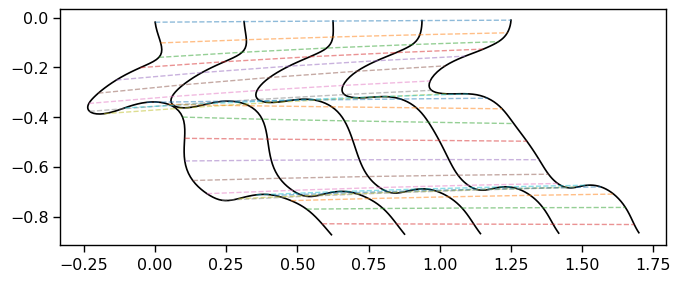

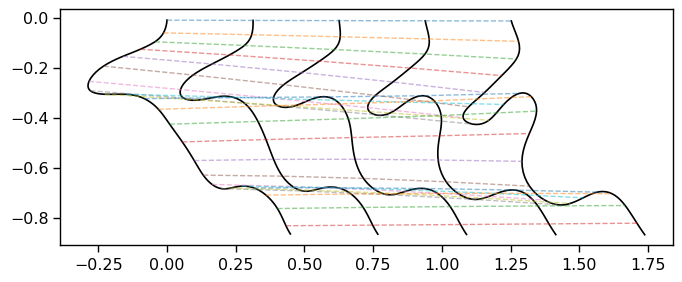

In [97]:
# base_curve = np.mean(tangent_projected_data, axis=0)
# sigma = np.std(tangent_projected_data, axis=0)
times = np.linspace(-3, 3, 5)  # 曲线的数量
synthetic_curves_by_component = []

# 用来记录第一条曲线的 y 方向高度
first_curve_y_range = None

# 计算等距的 x 轴偏移量
x_offsets = np.linspace(0, len(times) * 0.25, len(times))  # 生成等距的 x 轴偏移

for i in range(3):
    fig = plt.figure(figsize=(7, 3), dpi=100)
    ax = fig.add_subplot(111)
    all_points = []
    component_values = []

    # for idx, arr in enumerate(interpolated_arrays):

    for idx, t in enumerate(times):
        # ft = base_curve.copy()
        # ft[i] = ft[i] + t * sigma[i]
        # print (ft)
        # print ("--")
        # Reconstruct the curve
        ft = interpolated_arrays[i][idx]
        print (ft)
        print ("--")
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                        tPCA_N_COMPONENTS, 
                                                                        discrete_curves_space)[0]
        
        # Adjust the z-coordinate to separate the curves (assuming z is the 0th column)
        points = reconstructed_step_curve[:, [2, 1, 0]] * 2.5  # Adjust the order if necessary
        
        # 获取当前曲线的 y 坐标的最大值和最小值
        y_max = np.max(points[:, 1])
        y_min = np.min(points[:, 1])
        y_range = y_max - y_min

        if first_curve_y_range is None:
            # 如果是第一条曲线，记录它的 y 方向高度
            first_curve_y_range = y_range
        else:
            # 对其他曲线进行均匀缩放
            scale_factor = first_curve_y_range / y_range
            points *= scale_factor  # 对 x, y, z 坐标进行均匀缩放

        # 根据计算的等距偏移量移动曲线的第一个点在 x 轴方向上的位置
        points[:, 0] += x_offsets[idx]  # 使用等距偏移量
        plt.plot(points[:,0],points[:,1],color='k')
        
        all_points.append(points)
        component_values.append(t)
    all_points = np.array(all_points)
    plt.plot(all_points[:,::5,0],all_points[:,::5,1],linestyle='--', alpha=0.5, linewidth=1)
    plt.tight_layout()
    filename = "deform_{}.vtk".format(i)
    save_vtk_text(filename, all_points, len(times), component_values)

print ()


To-do: 根据peak在中点前还是中点后可以分类？
似乎通常peak都是中点，有少量意外